Will save outputs in: 20250107_101705_plots
Saved CSV files:
  20250107_101705_plots/curvature_marker.csv
  20250107_101705_plots/curvature_param.csv


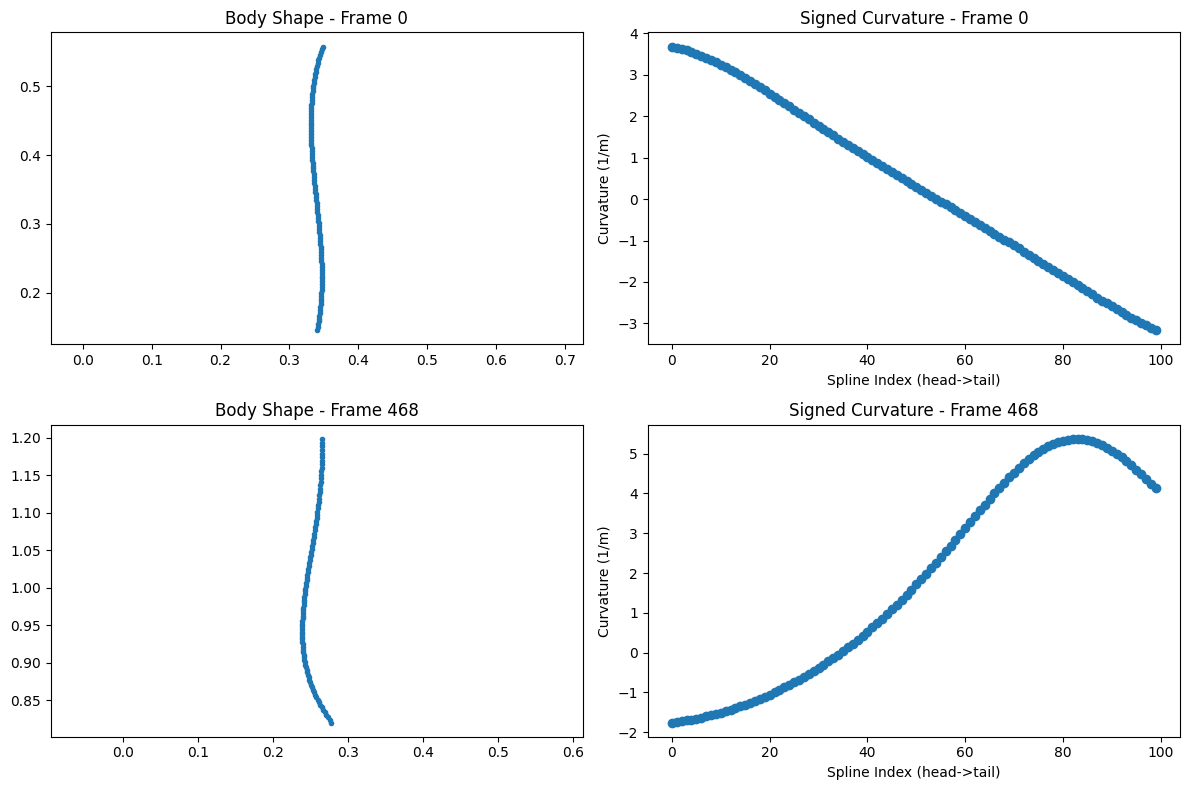

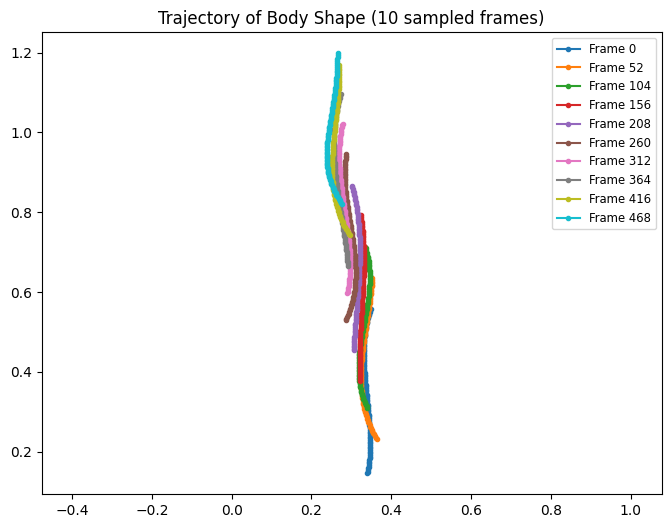

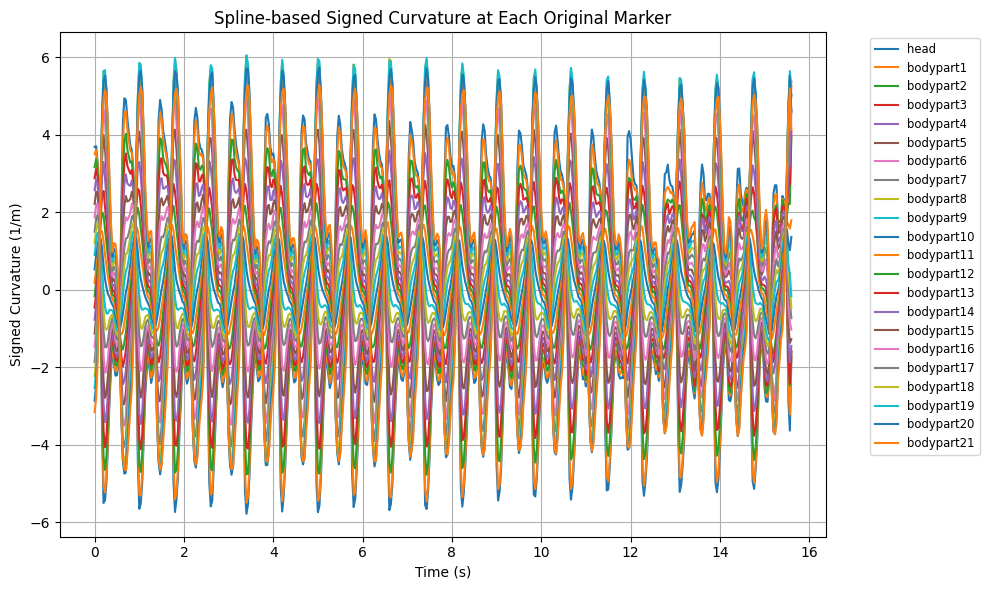

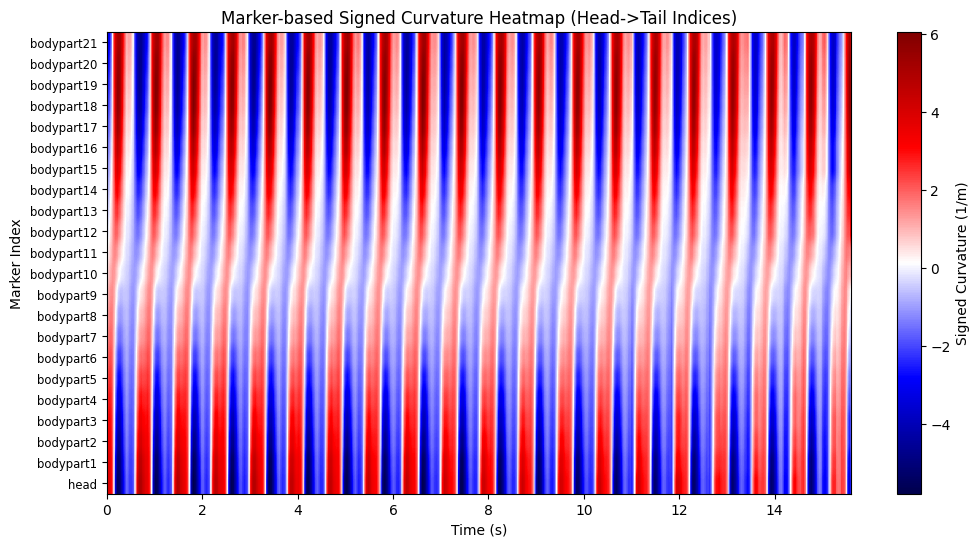

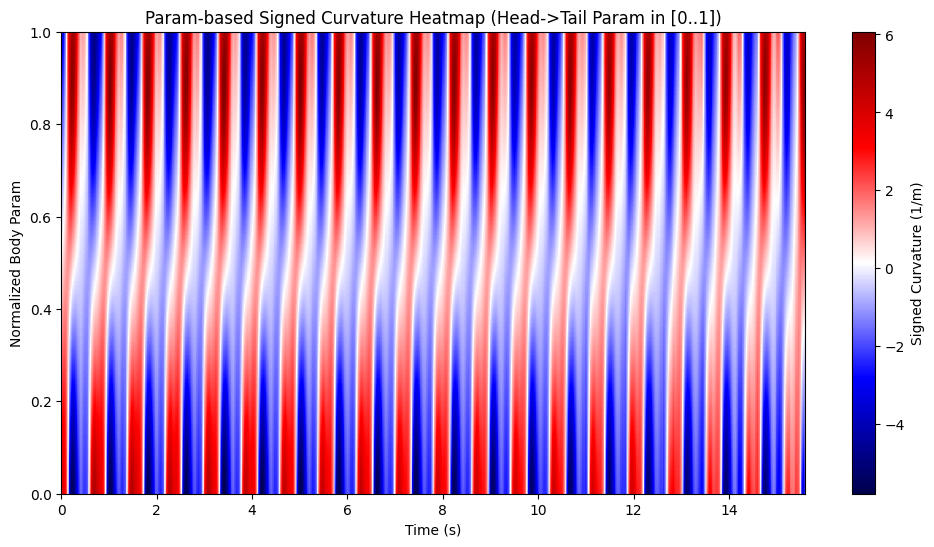

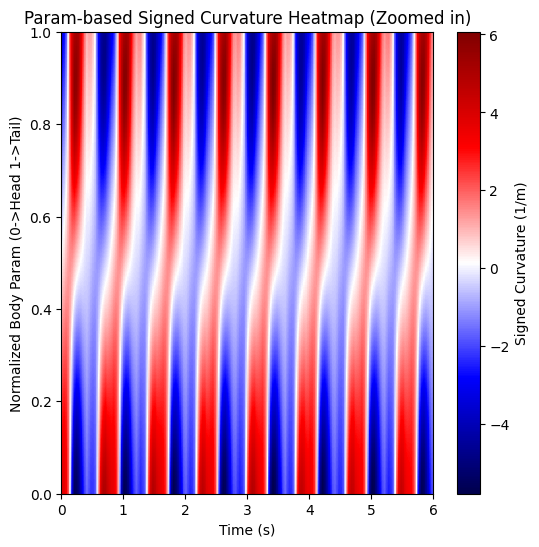


Done! Plots, CSV files, a copy of the original CSV, and cropped data are in: 20250107_101705_plots
Remember: curvature is in 1/m (signed) because x,y are in meters.


In [7]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
import shutil

##############################################################################
# 1) SETUP: CREATE A FOLDER TO STORE FIGURES & CSV
##############################################################################

timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
save_folder = f"{timestamp_str}_plots"
os.makedirs(save_folder, exist_ok=True)
print(f"Will save outputs in: {save_folder}")

##############################################################################
# 2) LOAD & PREP DATA
##############################################################################

# Path to your DLC-exported CSV
file_path = '/Users/jamesxu/Desktop/Crab Lab/surface swimmer/dlc_analysis/20250107_101513_plots_3pt/40cm_run4DLC_resnet50_40cm_newOct1shuffle1_100000_filtered.csv'

# Copy the *original* CSV into the output folder, too
shutil.copy2(file_path, os.path.join(save_folder, os.path.basename(file_path)))

# Real-world frame size (in meters)
real_width_m = 1.2
real_height_m = 0.55

# Video frame size (in pixels), ensuring same orientation
frame_width_pixels = 1920
frame_height_pixels = 884

# Video frame rate
video_fps = 30

# Load the CSV: the DLC multi-level headers are typically on rows 1 & 2 (0-based)
data = pd.read_csv(file_path, header=[1, 2])

# Extract 'x' and 'y' coordinates into separate DataFrames
x_coords = data.xs('x', level=1, axis=1)
y_coords = data.xs('y', level=1, axis=1)

# Drop rows with NaN (optional)
x_coords = x_coords.dropna()
y_coords = y_coords.dropna()

##############################################################################
# 2.1) (OPTIONAL) CROP THE DATA
##############################################################################
# If the beginning or ending frames are noisy, you can drop them here.
# Adjust 'n_drop_front' and 'n_drop_end' as needed. 
# If you only want to drop frames from the beginning, set n_drop_end = 0.

n_drop_front = 100  # e.g., drop first 100 frames
n_drop_end = 0      # e.g., drop last 0 frames (none)

# Handle the slicing
if n_drop_end > 0:
    x_coords = x_coords.iloc[n_drop_front:-n_drop_end]
    y_coords = y_coords.iloc[n_drop_front:-n_drop_end]
else:
    x_coords = x_coords.iloc[n_drop_front:]
    y_coords = y_coords.iloc[n_drop_front:]

def pixels_to_meters(x_pixels, y_pixels,
                     real_width_m=real_width_m, real_height_m=real_height_m,
                     frame_width_pixels=frame_width_pixels, frame_height_pixels=frame_height_pixels):
    """
    Convert pixel coordinates to real-world meters (assuming uniform scaling).
    """
    x_meters = x_pixels * (real_width_m / frame_width_pixels)
    y_meters = y_pixels * (real_height_m / frame_height_pixels)
    return x_meters, y_meters

# Convert from pixels -> meters
x_m, y_m = pixels_to_meters(x_coords, y_coords)

# Overwrite original x_coords, y_coords with meter-based coords
x_coords = x_m
y_coords = y_m

##############################################################################
# 3) SPLINE UTILITY FUNCTIONS (SIGNED CURVATURE)
##############################################################################

def compute_curvature_spline(x_points, y_points, num_points=100, smoothing=0.01):
    """
    Param-based spline with SIGNED curvature (units: 1/m if x,y in meters).
    k = (dx*ddy - dy*ddx) / ((dx^2 + dy^2)^(3/2))
    """
    tck, _ = splprep([x_points, y_points], s=smoothing, k=3)
    u_eval = np.linspace(0, 1, num_points)

    # Evaluate the spline and its derivatives
    x_spl, y_spl = splev(u_eval, tck, der=0)
    dx, dy       = splev(u_eval, tck, der=1)
    ddx, ddy     = splev(u_eval, tck, der=2)

    # Signed curvature
    signed_numerator = dx * ddy - dy * ddx
    denominator = (dx**2 + dy**2)**1.5

    curvature = np.zeros_like(signed_numerator)
    valid = denominator > 0
    curvature[valid] = signed_numerator[valid] / denominator[valid]

    return curvature, x_spl, y_spl

def compute_spline_curvatures_all_frames(x_df, y_df, num_points=100, smoothing=0.01):
    """
    Param-based approach for ALL frames (SIGNED curvature).
    Returns curvature in 1/m if x,y are in meters.
    """
    n_frames = x_df.shape[0]
    all_curv = np.zeros((n_frames, num_points))
    all_x_spl = []
    all_y_spl = []

    for i in range(n_frames):
        x_points = x_df.iloc[i].values
        y_points = y_df.iloc[i].values

        curv_i, xspl_i, yspl_i = compute_curvature_spline(
            x_points, y_points, num_points=num_points, smoothing=smoothing
        )
        all_curv[i, :] = curv_i
        all_x_spl.append(xspl_i)
        all_y_spl.append(yspl_i)

    return all_curv, all_x_spl, all_y_spl


def compute_marker_curvatures_spline(x_points, y_points, smoothing=0.01):
    """
    Marker-based spline with SIGNED curvature (units: 1/m if x,y in meters).
    """
    tck, u = splprep([x_points, y_points], s=smoothing, k=3)

    M = len(x_points)
    curvatures = np.zeros(M)
    for i in range(M):
        dx, dy   = splev(u[i], tck, der=1)
        ddx, ddy = splev(u[i], tck, der=2)

        signed_numerator = dx * ddy - dy * ddx
        denom = (dx**2 + dy**2)**1.5
        if denom > 0:
            curvatures[i] = signed_numerator / denom
        else:
            curvatures[i] = 0.0

    return curvatures

def compute_all_marker_curvatures_spline(x_df, y_df, smoothing=0.01):
    """
    Marker-based approach for ALL frames (SIGNED curvature), in 1/m if x,y in meters.
    """
    n_frames, n_markers = x_df.shape
    all_curv = np.zeros((n_frames, n_markers))

    for i in range(n_frames):
        x_points = x_df.iloc[i].values
        y_points = y_df.iloc[i].values
        curv_i = compute_marker_curvatures_spline(x_points, y_points, smoothing=smoothing)
        all_curv[i, :] = curv_i

    return all_curv

##############################################################################
# 4) COMPUTE CURVATURE (Marker-based & Param-based)
##############################################################################

smoothing_factor = 0.01
num_spline_points = 100

# (A) Marker-based (signed curvature)
curvatures_marker = compute_all_marker_curvatures_spline(
    x_coords, y_coords, smoothing=smoothing_factor
)

# (B) Param-based (signed curvature)
curvatures_param, x_splines, y_splines = compute_spline_curvatures_all_frames(
    x_coords, y_coords,
    num_points=num_spline_points,
    smoothing=smoothing_factor
)

N_frames = curvatures_marker.shape[0]
M_markers = curvatures_marker.shape[1]
time_s = np.arange(N_frames) / video_fps
markers_all = x_coords.columns  # or y_coords.columns
last_frame = N_frames - 1

##############################################################################
# 5) REMOVE EXTREME OUTLIERS (|curvature| > 6 => NaN)
##############################################################################
mask_marker = np.abs(curvatures_marker) > 100
curvatures_marker[mask_marker] = np.nan

mask_param = np.abs(curvatures_param) > 100
curvatures_param[mask_param] = np.nan

##############################################################################
# 6) SAVE CURVATURE DATA TO CSV
##############################################################################
df_marker = pd.DataFrame(curvatures_marker, columns=markers_all)
df_marker.insert(0, "Time_s", time_s)
marker_csv_path = os.path.join(save_folder, "curvature_marker.csv")
df_marker.to_csv(marker_csv_path, index=False)

df_param = pd.DataFrame(curvatures_param, columns=[f"param_{i}" for i in range(num_spline_points)])
df_param.insert(0, "Time_s", time_s)
param_csv_path = os.path.join(save_folder, "curvature_param.csv")
df_param.to_csv(param_csv_path, index=False)

print(f"Saved CSV files:\n  {marker_csv_path}\n  {param_csv_path}")

##############################################################################
# 7) PLOT: BODY SHAPE & CURVATURE FOR FRAME 0 AND LAST FRAME
##############################################################################
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Frame 0
axes[0, 0].plot(x_splines[0], y_splines[0], '-o', markersize=3)
axes[0, 0].set_title("Body Shape - Frame 0")
axes[0, 0].axis('equal')

axes[0, 1].plot(curvatures_param[0], '-o')
axes[0, 1].set_title("Signed Curvature - Frame 0")
axes[0, 1].set_xlabel("Spline Index (head->tail)")
axes[0, 1].set_ylabel("Curvature (1/m)")

# Last Frame
axes[1, 0].plot(x_splines[last_frame], y_splines[last_frame], '-o', markersize=3)
axes[1, 0].set_title(f"Body Shape - Frame {last_frame}")
axes[1, 0].axis('equal')

axes[1, 1].plot(curvatures_param[last_frame], '-o')
axes[1, 1].set_title(f"Signed Curvature - Frame {last_frame}")
axes[1, 1].set_xlabel("Spline Index (head->tail)")
axes[1, 1].set_ylabel("Curvature (1/m)")

plt.tight_layout()

fig_save_path = os.path.join(save_folder, "figure_bodyshape_first_last.png")
plt.savefig(fig_save_path, dpi=300)
plt.show()

##############################################################################
# 8) PLOT: TRAJECTORY OF THE SPLINE BODY SHAPE (Pick ~10 frames)
##############################################################################
n_samples = 10
sample_frames = np.linspace(0, last_frame, n_samples, dtype=int)

plt.figure(figsize=(8, 6))
for f_idx in sample_frames:
    plt.plot(x_splines[f_idx], y_splines[f_idx], '-o', markersize=3, label=f"Frame {f_idx}")

plt.title("Trajectory of Body Shape (10 sampled frames)")
plt.axis('equal')
plt.legend(loc='best', fontsize='small')

plot_path_trajectory = os.path.join(save_folder, "figure_trajectory.png")
plt.savefig(plot_path_trajectory, dpi=300)
plt.show()

##############################################################################
# 9) PLOT #1: Curvature vs. Time for Each Marker (Marker-based)
##############################################################################
plt.figure(figsize=(10, 6))
for i, marker_name in enumerate(markers_all):
    plt.plot(time_s, curvatures_marker[:, i], label=marker_name)

plt.xlabel('Time (s)')
plt.ylabel('Signed Curvature (1/m)')
plt.title('Spline-based Signed Curvature at Each Original Marker')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()

plot_path_marker_time = os.path.join(save_folder, "figure_curvature_vs_time.png")
plt.savefig(plot_path_marker_time, dpi=300)
plt.show()

##############################################################################
# 10) PLOT #2: Marker-based Curvature Heatmap
##############################################################################
plt.figure(figsize=(12, 6))
im = plt.imshow(
    curvatures_marker.T,
    aspect='auto',
    origin='lower',
    extent=[time_s[0], time_s[-1], 0, M_markers],
    cmap='seismic'
)
plt.colorbar(im, label='Signed Curvature (1/m)')
plt.title('Marker-based Signed Curvature Heatmap (Head->Tail Indices)')
plt.xlabel('Time (s)')
plt.ylabel('Marker Index')

y_positions = np.arange(M_markers) + 0.5
plt.yticks(y_positions, markers_all, fontsize='small')

plot_path_marker_heat = os.path.join(save_folder, "figure_marker_heatmap.png")
plt.savefig(plot_path_marker_heat, dpi=300)
plt.show()

##############################################################################
# 11) PLOT #3: Param-based Curvature Heatmap (Non-Discretized)
##############################################################################
plt.figure(figsize=(12, 6))
im2 = plt.imshow(
    curvatures_param.T,
    aspect='auto',
    origin='lower',
    extent=[time_s[0], time_s[-1], 0, 1],
    cmap='seismic'
)
plt.colorbar(im2, label='Signed Curvature (1/m)')
plt.title('Param-based Signed Curvature Heatmap (Head->Tail Param in [0..1])')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Body Param')

plot_path_param_heat = os.path.join(save_folder, "figure_param_heatmap.png")
plt.savefig(plot_path_param_heat, dpi=300)
plt.show()

##############################################################################
# 12) ZOOMED-IN PLOT
##############################################################################
plt.figure(figsize=(6, 6))
im3 = plt.imshow(
    curvatures_param.T,
    aspect='auto',
    origin='lower',
    extent=[time_s[0], time_s[-1], 0, 1],
    cmap='seismic'
)
plt.colorbar(im3, label='Signed Curvature (1/m)')
plt.title('Param-based Signed Curvature Heatmap (Zoomed in)')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Body Param (0->Head 1->Tail)')
plt.xlim(0,6)

plot_path_zoomed = os.path.join(save_folder, "figure_zoomed.png")
plt.savefig(plot_path_zoomed, dpi=300)
plt.show()

print("\nDone! Plots, CSV files, a copy of the original CSV, and cropped data are in:", save_folder)
print("Remember: curvature is in 1/m (signed) because x,y are in meters.")


Saved animation GIF to: 20241231_204236_plots/spline_animation.gif


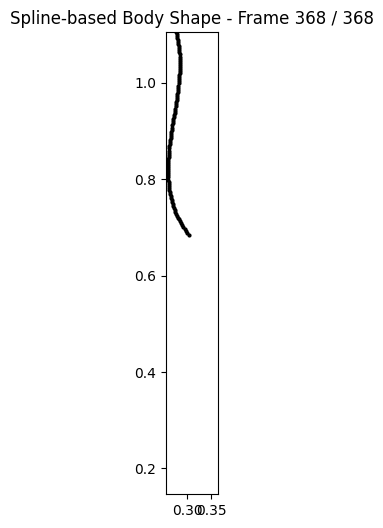

In [109]:
# import matplotlib.animation as animation

# ##############################################################################
# # 13) ANIMATION: CREATE AN ANIMATED GIF OF THE SPLINED TRAJECTORY
# #     Larger canvas + smaller dot for clarity
# ##############################################################################

# # We'll figure out the global min/max X,Y so our animation axes stay fixed.
# all_x = np.concatenate(x_splines)
# all_y = np.concatenate(y_splines)
# min_x, max_x = np.min(all_x), np.max(all_x)
# min_y, max_y = np.min(all_y), np.max(all_y)

# # Create figure & axes for animation
# fig_anim, ax_anim = plt.subplots(figsize=(8, 6))  # Larger figure
# ax_anim.set_xlim(min_x, max_x)
# ax_anim.set_ylim(min_y, max_y)
# ax_anim.set_aspect('equal', adjustable='box')
# ax_anim.set_title('Spline-based Body Shape Over Time')

# # We'll keep a single line object that we'll update for each frame.
# # Decrease markersize for a finer view of the spline.
# line_obj, = ax_anim.plot([], [], 'o-', linewidth=1, markersize=2, color='black')

# def init():
#     """Initialize the background of the animation."""
#     line_obj.set_data([], [])
#     return (line_obj,)

# def update(frame):
#     """
#     For each frame, update the line data to the parametric spline 
#     x_splines[frame], y_splines[frame].
#     """
#     xdata = x_splines[frame]
#     ydata = y_splines[frame]
#     line_obj.set_data(xdata, ydata)
#     ax_anim.set_title(f"Spline-based Body Shape - Frame {frame} / {N_frames - 1}")
#     return (line_obj,)

# # Create the animation
# ani = animation.FuncAnimation(
#     fig_anim,
#     update,
#     frames=N_frames,    # Or range(0, N_frames, step)
#     init_func=init,
#     blit=True,
#     interval=50         # Delay between frames in ms for the on-screen preview
# )

# # Save as GIF (using Pillow writer). Adjust 'fps' to control playback speed in the GIF.
# anim_gif_path = os.path.join(save_folder, "spline_animation.gif")
# ani.save(anim_gif_path, writer='pillow', fps=20)
# print(f"Saved animation GIF to: {anim_gif_path}")


Saved animation GIF to: 20250102_065621_plots/spline_markers_animation.gif


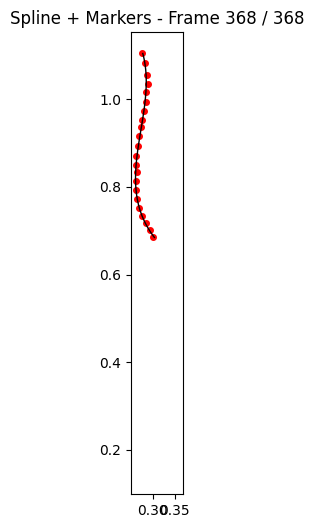

In [119]:
# ##############################################################################
# # 13) ANIMATION: CREATE AN ANIMATED GIF WITH MARKERS + SPLINE
# ##############################################################################

# import matplotlib.animation as animation

# # 1) Determine global min/max X and Y across *all frames* 
# #    so the animation axes stay consistent.
# all_x_values = []
# all_y_values = []

# # (a) Add original marker coords
# #    x_coords, y_coords are DataFrames of shape (N_frames, M_markers)
# all_x_values.append(x_coords.values.flatten())
# all_y_values.append(y_coords.values.flatten())

# # (b) Add spline coords
# #    x_splines, y_splines are lists of length N_frames,
# #    each an array of shape (num_spline_points,).
# for i in range(N_frames):
#     all_x_values.append(x_splines[i])
#     all_y_values.append(y_splines[i])

# all_x_values = np.concatenate(all_x_values)
# all_y_values = np.concatenate(all_y_values)

# min_x, max_x = np.nanmin(all_x_values), np.nanmax(all_x_values)
# min_y, max_y = np.nanmin(all_y_values), np.nanmax(all_y_values)

# # Optionally add a small margin (percentage) around the data
# margin_factor = 0.05
# dx = max_x - min_x
# dy = max_y - min_y
# min_x -= margin_factor * dx
# max_x += margin_factor * dx
# min_y -= margin_factor * dy
# max_y += margin_factor * dy

# # 2) Create figure & axis for animation
# fig_anim, ax_anim = plt.subplots(figsize=(8, 6))

# ax_anim.set_xlim(min_x, max_x)
# ax_anim.set_ylim(min_y, max_y)
# ax_anim.set_aspect('equal', adjustable='box')
# ax_anim.set_title('Spline-based Body Shape Over Time')

# # 3) We will keep TWO artists:
# #    (a) marker_obj for the red dots (original markers)
# #    (b) spline_obj for the black line (spline)
# # We'll update them each frame in the "update" function.

# marker_obj, = ax_anim.plot([], [], 'o', color='red', markersize=4, label='Markers')
# spline_obj, = ax_anim.plot([], [], '-k', linewidth=1, label='Spline')

# def init():
#     """Initialize the animation background (empty data)."""
#     marker_obj.set_data([], [])
#     spline_obj.set_data([], [])
#     return (marker_obj, spline_obj)

# def update(frame):
#     """
#     For each frame, show:
#       - The original marker positions x_coords, y_coords
#       - The fitted spline x_splines[frame], y_splines[frame]
#     """
#     # Markers
#     x_markers = x_coords.iloc[frame].values  # shape (M_markers,)
#     y_markers = y_coords.iloc[frame].values
#     marker_obj.set_data(x_markers, y_markers)
    
#     # Spline
#     x_spl = x_splines[frame]
#     y_spl = y_splines[frame]
#     spline_obj.set_data(x_spl, y_spl)
    
#     ax_anim.set_title(f"Spline + Markers - Frame {frame} / {N_frames - 1}")
#     return (marker_obj, spline_obj)

# # 4) Create the animation using FuncAnimation
# ani = animation.FuncAnimation(
#     fig_anim,
#     update,
#     frames=range(N_frames),
#     init_func=init,
#     blit=True,
#     interval=100  # ms delay between frames in interactive preview
# )

# # 5) Save as GIF (using the Pillow writer). 
# #    Adjust 'fps' to control playback speed in the final GIF.
# gif_path = os.path.join(save_folder, "spline_markers_animation.gif")
# ani.save(gif_path, writer='pillow', fps=30)
# print(f"Saved animation GIF to: {gif_path}")


Will save outputs in: 20250107_123129_plots_3pt_signed
Saved 3-point SIGNED curvature CSV => 20250107_123129_plots_3pt_signed/curvature_param_3pt_signed.csv


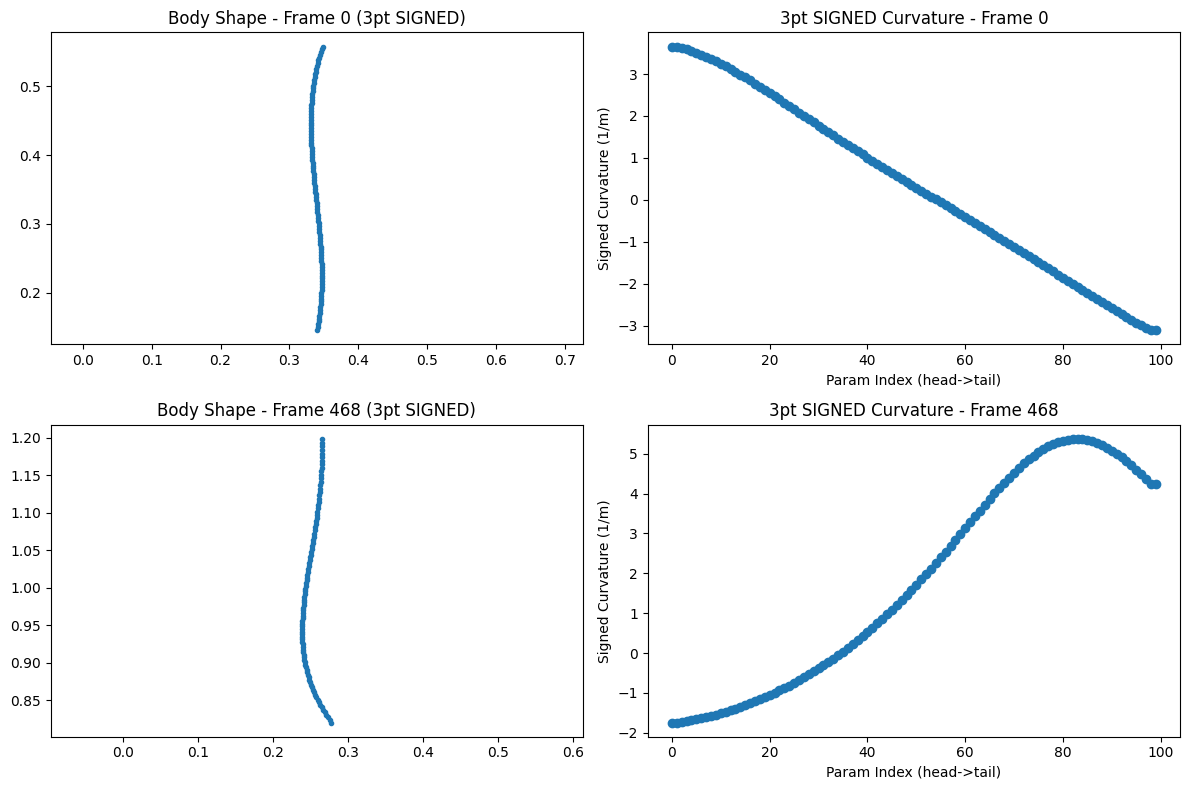

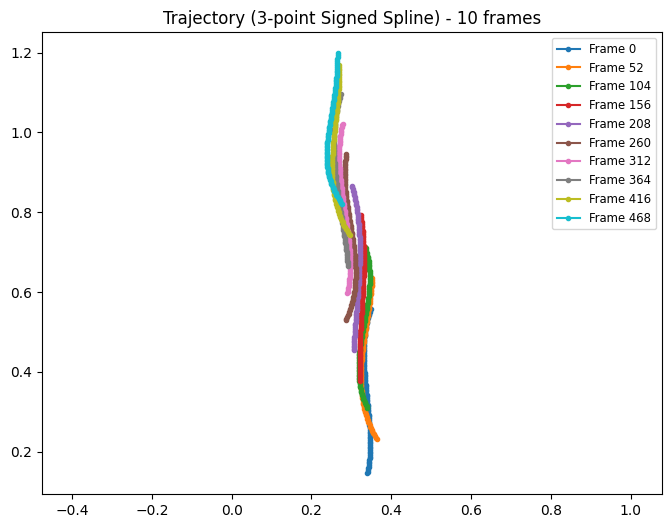

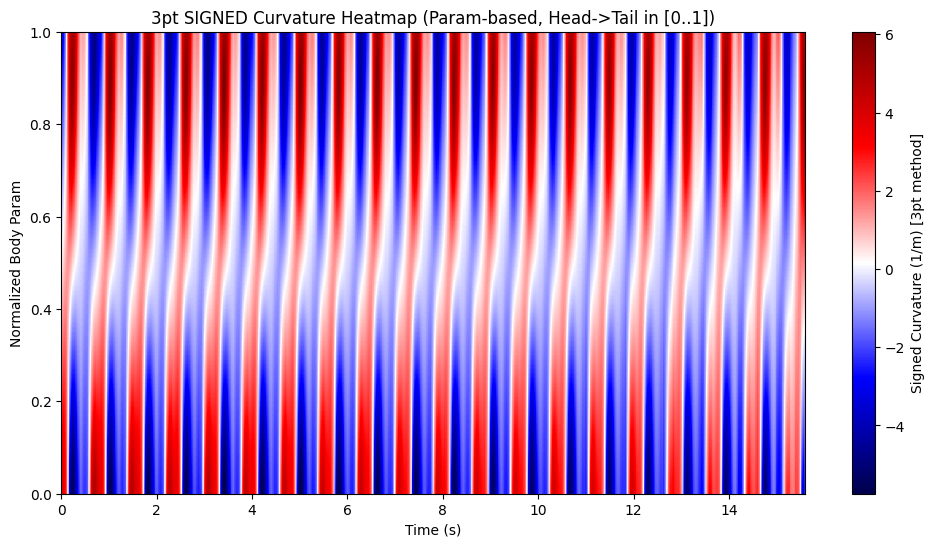

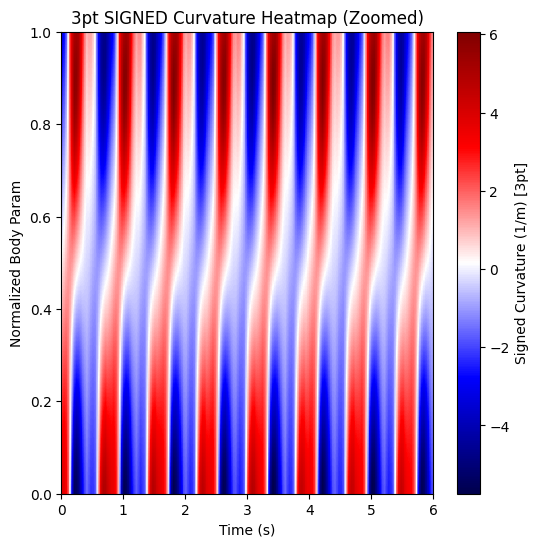


Done! Plots, CSV, and a copy of the original CSV are in: 20250107_123129_plots_3pt_signed
Curvature computed via 3-pt geometry on the spline points (SIGNED, in 1/m).


In [8]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
import shutil

##############################################################################
# 1) SETUP: CREATE A FOLDER TO STORE FIGURES & CSV
##############################################################################

timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
save_folder = f"{timestamp_str}_plots_3pt_signed"
os.makedirs(save_folder, exist_ok=True)
print(f"Will save outputs in: {save_folder}")

##############################################################################
# 2) LOAD & PREP DATA
##############################################################################

file_path = '/Users/jamesxu/Desktop/Crab Lab/surface swimmer/dlc_analysis/40cm_noThresh_trial_2/40cm_run4DLC_resnet50_40cm_newOct1shuffle1_100000_filtered.csv'

# Copy the *original* CSV into the output folder, too
shutil.copy2(file_path, os.path.join(save_folder, os.path.basename(file_path)))

# Real-world frame size (in meters)
real_width_m = 1.2
real_height_m = 0.55

# Video frame size (in pixels), ensuring same orientation
frame_width_pixels = 1920
frame_height_pixels = 884

# Video frame rate
video_fps = 30

# Load the CSV (DLC multi-level headers: rows 1 & 2)
data = pd.read_csv(file_path, header=[1, 2])

# Extract 'x' and 'y' coordinates; drop rows with NaN
x_coords = data.xs('x', level=1, axis=1).dropna()
y_coords = data.xs('y', level=1, axis=1).dropna()

##############################################################################
# 2.1) (OPTIONAL) CROP THE DATA
##############################################################################
n_drop_front = 100
n_drop_end = 0

if n_drop_end > 0:
    x_coords = x_coords.iloc[n_drop_front:-n_drop_end]
    y_coords = y_coords.iloc[n_drop_front:-n_drop_end]
else:
    x_coords = x_coords.iloc[n_drop_front:]
    y_coords = y_coords.iloc[n_drop_front:]

##############################################################################
# 2.2) CONVERT PIXELS -> METERS
##############################################################################
def pixels_to_meters(x_pixels, y_pixels,
                     real_width_m=real_width_m, real_height_m=real_height_m,
                     frame_width_pixels=frame_width_pixels, frame_height_pixels=frame_height_pixels):
    """
    Convert pixel coords to real-world meters (assuming uniform scaling).
    """
    x_meters = x_pixels * (real_width_m / frame_width_pixels)
    y_meters = y_pixels * (real_height_m / frame_height_pixels)
    return x_meters, y_meters

x_m, y_m = pixels_to_meters(x_coords, y_coords)
x_coords = x_m
y_coords = y_m

##############################################################################
# 3) 3-POINT CURVATURE (SIGNED) UTILITY
##############################################################################
def curvature_3pt_signed(A, B, C):
    """
    Compute SIGNED curvature from three points A,B,C in 2D:
      A,B,C are [x,y].
    Using the formula:
      k = ± [ 4 * Area(ABC) ] / ( |AB| * |BC| * |CA| )
    with the sign determined by the cross product (A->B) x (A->C).
    
    If cross_z >= 0 => positive curvature
    else => negative curvature
    """
    AB = B - A
    AC = C - A
    cross_z = AB[0]*AC[1] - AB[1]*AC[0]  # 2D cross product (z-component)
    
    # Heron's formula approach => area of triangle
    area_ABC = 0.5 * abs(cross_z)
    
    AB_len = np.linalg.norm(AB)
    BC_len = np.linalg.norm(C - B)
    CA_len = np.linalg.norm(A - C)

    denom = AB_len * BC_len * CA_len
    if denom < 1e-12:  # degenerate triangle
        return 0.0

    # Unsigned curvature
    k_unsigned = 4.0 * area_ABC / denom

    # Determine sign from cross_z
    if cross_z >= 0:
        return k_unsigned   # left turn or no turn
    else:
        return -k_unsigned  # right turn

##############################################################################
# 3.1) SPLINE + 3-POINT (SIGNED) CURVATURE
##############################################################################
def compute_curvature_spline_3pt_signed(x_points, y_points, num_points=100, smoothing=0.01):
    """
    1) Fit a cubic spline to (x_points,y_points) in param u=[0..1].
    2) Evaluate at `num_points` param values.
    3) For each interior i, compute a SIGNED 3-point curvature using i-1, i, i+1.
    Returns:
       curvature_vals: shape (num_points,)  (signed)
       x_spl, y_spl:   each shape (num_points,)
    """
    # 1) Fit a spline
    tck, _ = splprep([x_points, y_points], s=smoothing, k=3)
    u_eval = np.linspace(0, 1, num_points)

    # 2) Evaluate the spline at these param points
    x_spl, y_spl = splev(u_eval, tck, der=0)
    coords_spl = np.column_stack([x_spl, y_spl])  # shape (num_points, 2)

    # 3) 3-point curvature: i in [1..num_points-2]
    curvature_vals = np.zeros(num_points)
    for i in range(1, num_points-1):
        A = coords_spl[i-1]
        B = coords_spl[i]
        C = coords_spl[i+1]
        curvature_vals[i] = curvature_3pt_signed(A, B, C)

    # Endpoints can replicate neighbors or set to 0
    curvature_vals[0] = curvature_vals[1]
    curvature_vals[-1] = curvature_vals[-2]

    return curvature_vals, x_spl, y_spl

def compute_spline_curvatures_all_frames_3pt_signed(x_df, y_df, num_points=100, smoothing=0.01):
    """
    For each frame, compute param-based SIGNED 3-pt curvature.
    Return shape => (N_frames, num_points) + lists of x_spl, y_spl.
    """
    n_frames = x_df.shape[0]
    all_curv = np.zeros((n_frames, num_points))
    all_x_spl = []
    all_y_spl = []

    for i in range(n_frames):
        x_pts = x_df.iloc[i].values
        y_pts = y_df.iloc[i].values
        curv_i, x_spl_i, y_spl_i = compute_curvature_spline_3pt_signed(
            x_pts, y_pts,
            num_points=num_points,
            smoothing=smoothing
        )
        all_curv[i,:] = curv_i
        all_x_spl.append(x_spl_i)
        all_y_spl.append(y_spl_i)

    return all_curv, all_x_spl, all_y_spl

##############################################################################
# 4) COMPUTE CURVATURE (SIGNED) VIA 3-POINT
##############################################################################
smoothing_factor = 0.01
num_spline_points = 100

curvatures_param_3pt_signed, x_splines_3pt_signed, y_splines_3pt_signed = \
    compute_spline_curvatures_all_frames_3pt_signed(
        x_coords, y_coords,
        num_points=num_spline_points,
        smoothing=smoothing_factor
    )

N_frames = curvatures_param_3pt_signed.shape[0]
time_s = np.arange(N_frames) / video_fps
last_frame = N_frames - 1

##############################################################################
# 5) REMOVE EXTREME OUTLIERS
##############################################################################
mask_param_3pt = np.abs(curvatures_param_3pt_signed) > 100
curvatures_param_3pt_signed[mask_param_3pt] = np.nan

##############################################################################
# 6) SAVE CURVATURE DATA TO CSV
##############################################################################
df_param_3pt_signed = pd.DataFrame(
    curvatures_param_3pt_signed,
    columns=[f"param_{i}" for i in range(num_spline_points)]
)
df_param_3pt_signed.insert(0, "Time_s", time_s)

param_csv_path_3pt_signed = os.path.join(save_folder, "curvature_param_3pt_signed.csv")
df_param_3pt_signed.to_csv(param_csv_path_3pt_signed, index=False)

print(f"Saved 3-point SIGNED curvature CSV => {param_csv_path_3pt_signed}")

##############################################################################
# 7) PLOTS
##############################################################################
### 7.1 BODY SHAPE & CURVATURE FOR FRAME 0 & LAST FRAME
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(x_splines_3pt_signed[0], y_splines_3pt_signed[0], '-o', markersize=3)
axes[0, 0].set_title("Body Shape - Frame 0 (3pt SIGNED)")
axes[0, 0].axis('equal')

axes[0, 1].plot(curvatures_param_3pt_signed[0], '-o')
axes[0, 1].set_title("3pt SIGNED Curvature - Frame 0")
axes[0, 1].set_xlabel("Param Index (head->tail)")
axes[0, 1].set_ylabel("Signed Curvature (1/m)")

axes[1, 0].plot(x_splines_3pt_signed[last_frame], y_splines_3pt_signed[last_frame], '-o', markersize=3)
axes[1, 0].set_title(f"Body Shape - Frame {last_frame} (3pt SIGNED)")
axes[1, 0].axis('equal')

axes[1, 1].plot(curvatures_param_3pt_signed[last_frame], '-o')
axes[1, 1].set_title(f"3pt SIGNED Curvature - Frame {last_frame}")
axes[1, 1].set_xlabel("Param Index (head->tail)")
axes[1, 1].set_ylabel("Signed Curvature (1/m)")

plt.tight_layout()
fig_save_path = os.path.join(save_folder, "figure_bodyshape_first_last_3pt_signed.png")
plt.savefig(fig_save_path, dpi=300)
plt.show()

### 7.2 TRAJECTORY OF THE SPLINE (~10 frames)
n_samples = 10
sample_frames = np.linspace(0, last_frame, n_samples, dtype=int)

plt.figure(figsize=(8,6))
for f_idx in sample_frames:
    plt.plot(x_splines_3pt_signed[f_idx], y_splines_3pt_signed[f_idx], '-o', markersize=3, label=f"Frame {f_idx}")

plt.title("Trajectory (3-point Signed Spline) - 10 frames")
plt.axis('equal')
plt.legend(loc='best', fontsize='small')

plot_path_trajectory = os.path.join(save_folder, "figure_trajectory_3pt_signed.png")
plt.savefig(plot_path_trajectory, dpi=300)
plt.show()

### 7.3 PARAM-BASED Curvature Heatmap (Signed)
plt.figure(figsize=(12,6))
im = plt.imshow(
    curvatures_param_3pt_signed.T,
    aspect='auto',
    origin='lower',
    extent=[time_s[0], time_s[-1], 0, 1],
    cmap='seismic'  # highlight negative vs positive
)
plt.colorbar(im, label='Signed Curvature (1/m) [3pt method]')
plt.title('3pt SIGNED Curvature Heatmap (Param-based, Head->Tail in [0..1])')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Body Param')

plot_path_heatmap = os.path.join(save_folder, "figure_param_heatmap_3pt_signed.png")
plt.savefig(plot_path_heatmap, dpi=300)
plt.show()

### 7.4 ZOOMED-IN PLOT
plt.figure(figsize=(6,6))
im2 = plt.imshow(
    curvatures_param_3pt_signed.T,
    aspect='auto',
    origin='lower',
    extent=[time_s[0], time_s[-1], 0, 1],
    cmap='seismic'
)
plt.colorbar(im2, label='Signed Curvature (1/m) [3pt]')
plt.title('3pt SIGNED Curvature Heatmap (Zoomed)')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Body Param')
plt.xlim(0, 6)

plot_path_zoomed = os.path.join(save_folder, "figure_zoomed_3pt_signed.png")
plt.savefig(plot_path_zoomed, dpi=300)
plt.show()

print("\nDone! Plots, CSV, and a copy of the original CSV are in:", save_folder)
print("Curvature computed via 3-pt geometry on the spline points (SIGNED, in 1/m).")


Will save outputs in: 20250110_134703_plots_markerCurv
Saved smoothed spline data to:
  20250110_134703_plots_markerCurv/spline_marker_x.csv
  20250110_134703_plots_markerCurv/spline_marker_y.csv
Saved unthresholded curvature CSVs:
  3pt => 20250110_134703_plots_markerCurv/curvature_marker_3pt_raw.csv
  circ5 => 20250110_134703_plots_markerCurv/curvature_marker_circ5_signed_raw.csv


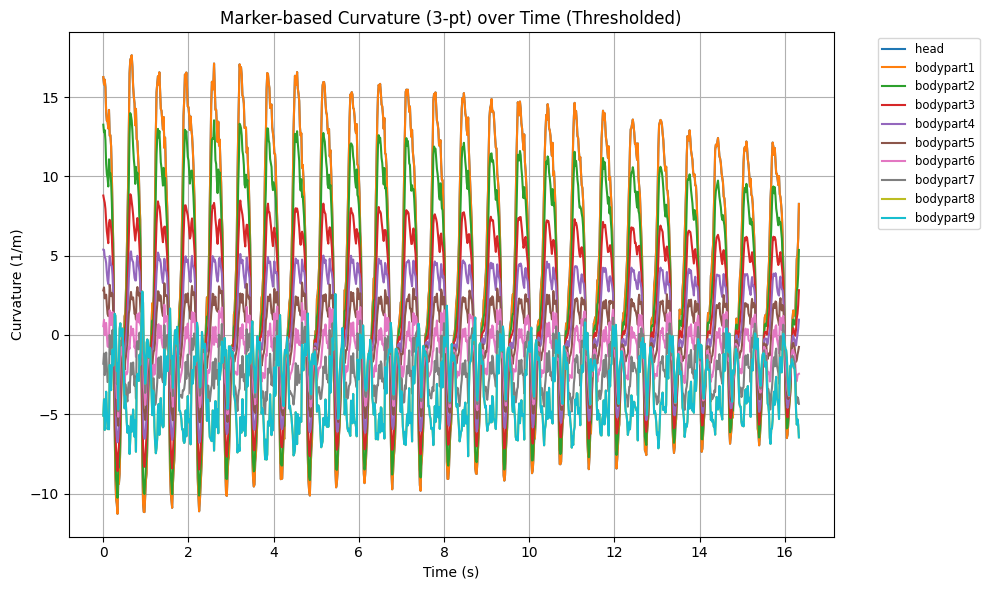

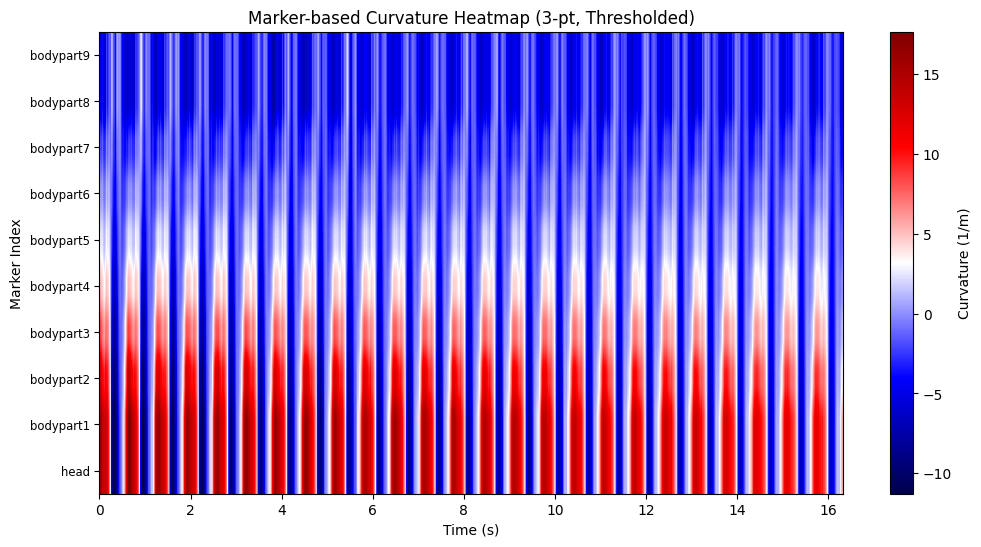

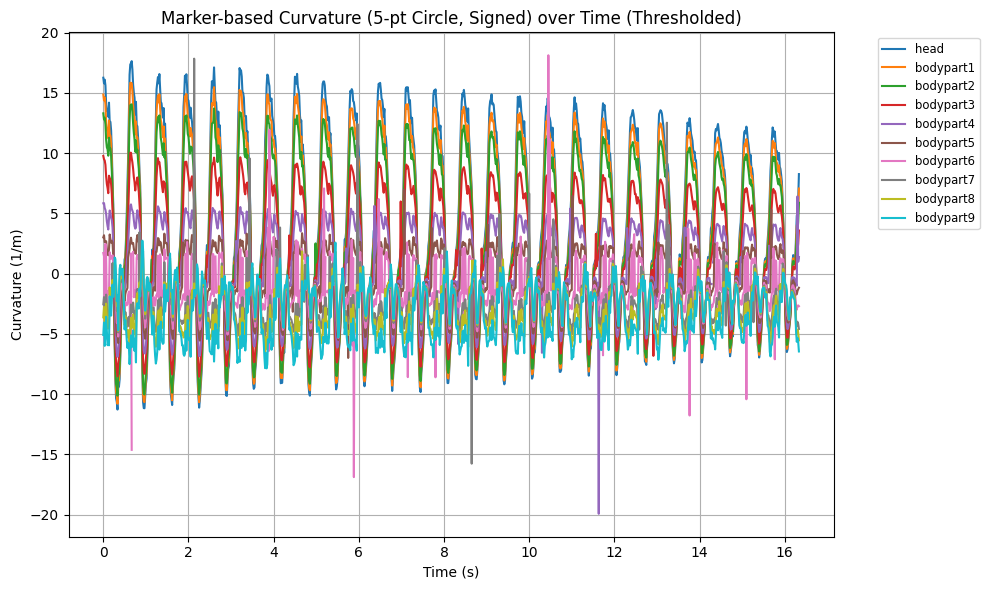

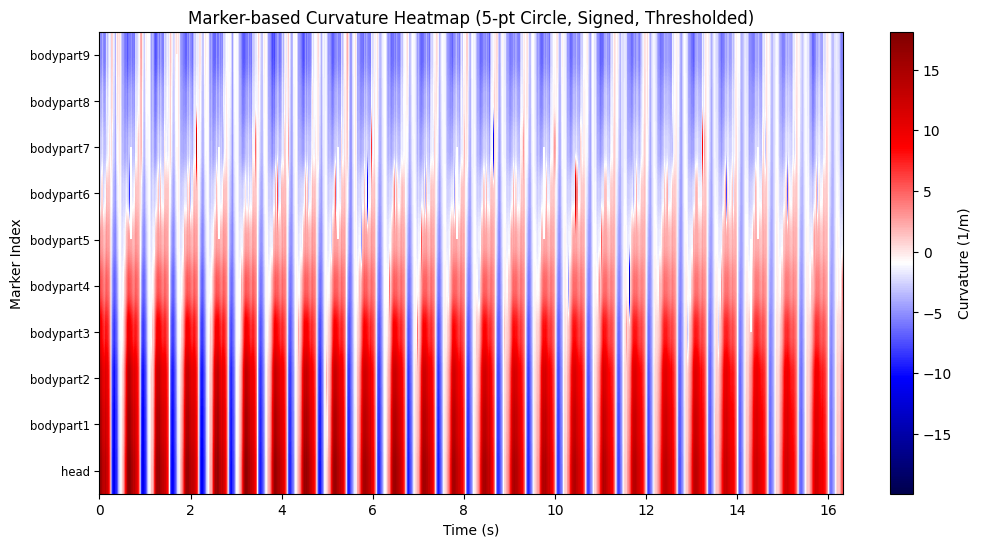

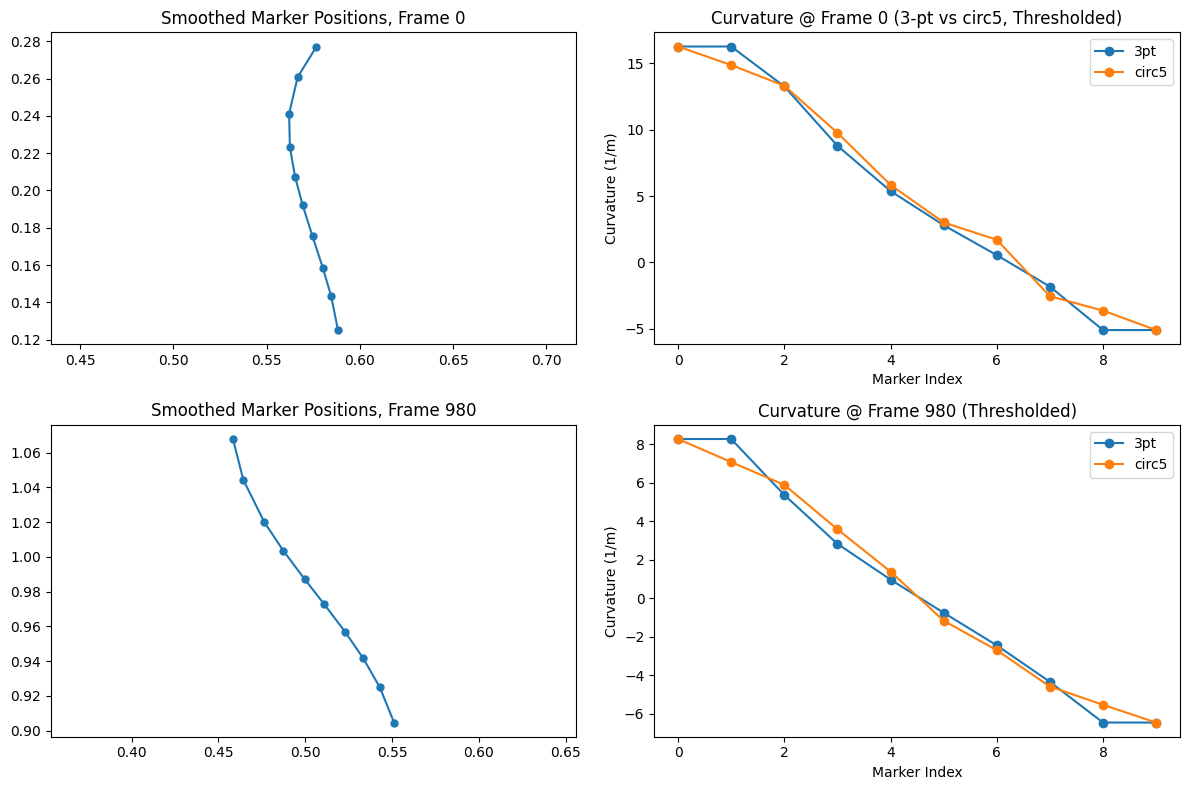

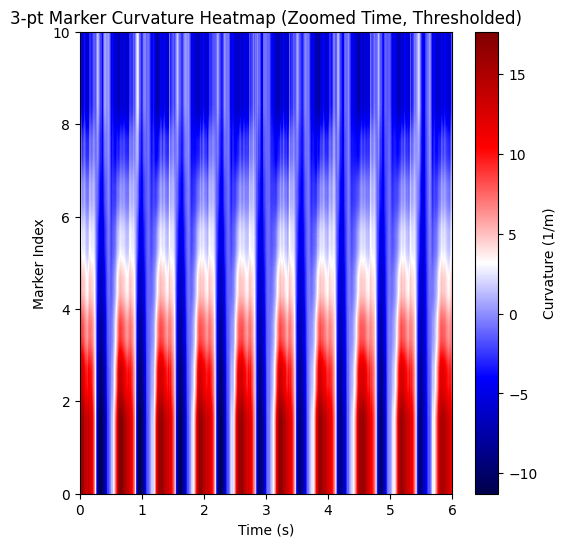

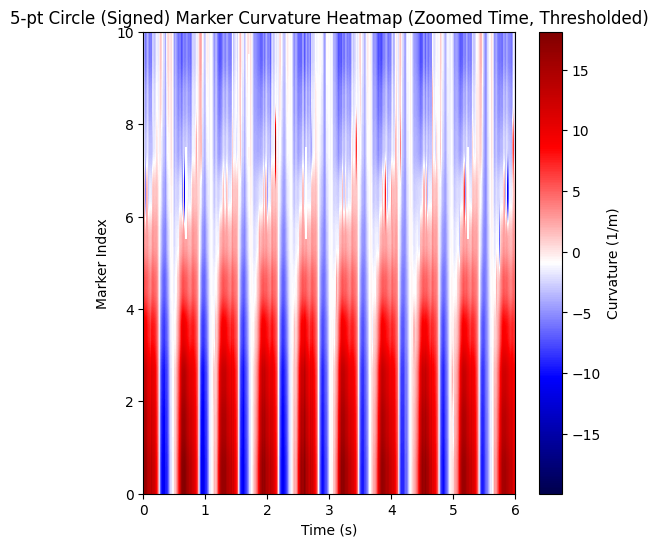


DONE! All data, CSV (unthresholded), and thresholded plots are in: 20250110_134703_plots_markerCurv
1) Spline fit data saved. 2) Curv(3-pt) & Curv(circ5) saved raw. 3) Threshold applies only for plots.


In [48]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
import shutil

##############################################################################
# 1) CREATE OUTPUT FOLDER & LOAD DATA
##############################################################################

timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
save_folder = f"{timestamp_str}_plots_markerCurv"
os.makedirs(save_folder, exist_ok=True)
print(f"Will save outputs in: {save_folder}")

file_path ='/Users/jamesxu/Desktop/Crab Lab/surface swimmer/dlc_analysis/16cm_noThresh_trial_3/16cm_run6DLC_resnet50_16cm_newOct3shuffle1_100000_filtered.csv'
shutil.copy2(file_path, os.path.join(save_folder, os.path.basename(file_path)))

# Real-world frame size
real_width_m = 1.2
real_height_m = 0.675
frame_width_pixels = 1920
frame_height_pixels = 1080
video_fps = 60

# Load the multi-level DLC CSV
data = pd.read_csv(file_path, header=[1, 2])
x_coords = data.xs('x', level=1, axis=1).dropna()
y_coords = data.xs('y', level=1, axis=1).dropna()

# (Optional) Crop
n_drop_front = 100
n_drop_end   = 100
if n_drop_end > 0:
    x_coords = x_coords.iloc[n_drop_front:-n_drop_end]
    y_coords = y_coords.iloc[n_drop_front:-n_drop_end]
else:
    x_coords = x_coords.iloc[n_drop_front:]
    y_coords = y_coords.iloc[n_drop_front:]

def pixels_to_meters(x_pixels, y_pixels,
                     real_width_m=real_width_m, real_height_m=real_height_m,
                     frame_width_pixels=frame_width_pixels, frame_height_pixels=frame_height_pixels):
    x_m = x_pixels * (real_width_m / frame_width_pixels)
    y_m = y_pixels * (real_height_m / frame_height_pixels)
    return x_m, y_m

x_m, y_m = pixels_to_meters(x_coords, y_coords)
x_coords = x_m
y_coords = y_m

N_frames = x_coords.shape[0]
M_markers = x_coords.shape[1]
markers_all = x_coords.columns
time_s = np.arange(N_frames) / video_fps
last_frame = N_frames - 1

##############################################################################
# 2) FIT SPLINE FOR EACH FRAME & SAVE SMOOTHED MARKER COORDS
##############################################################################

def fit_spline_and_get_marker_coords(x_points, y_points, smoothing=0.01):
    """
    1) Fit a spline to these M markers (x_points,y_points).
    2) Return the smoothed coords for each marker, shape (M,2).
       We do: tck,u = splprep([x_points,y_points]) => splev(u[i], tck).
    """
    tck, u = splprep([x_points, y_points], s=smoothing, k=3)
    M = len(x_points)
    coords_spl = np.zeros((M, 2))
    for i in range(M):
        coords_spl[i] = splev(u[i], tck, der=0)  # x_spl, y_spl
    return coords_spl

smoothing_factor = 0.01
x_spline_df = pd.DataFrame(np.zeros((N_frames, M_markers)), columns=markers_all)
y_spline_df = pd.DataFrame(np.zeros((N_frames, M_markers)), columns=markers_all)

for i in range(N_frames):
    x_pts = x_coords.iloc[i].values
    y_pts = y_coords.iloc[i].values
    coords_spl = fit_spline_and_get_marker_coords(x_pts, y_pts, smoothing=smoothing_factor)
    x_spline_df.iloc[i] = coords_spl[:,0]
    y_spline_df.iloc[i] = coords_spl[:,1]

# Save the smoothed (x,y) for each marker
csv_x_spline = os.path.join(save_folder, "spline_marker_x.csv")
csv_y_spline = os.path.join(save_folder, "spline_marker_y.csv")
x_spline_df.to_csv(csv_x_spline, index=False)
y_spline_df.to_csv(csv_y_spline, index=False)
print("Saved smoothed spline data to:")
print(f"  {csv_x_spline}\n  {csv_y_spline}")

##############################################################################
# 3) DEFINE TWO CURVATURE METHODS (SIGNED)
##############################################################################

def curvature_3pt_signed(A, B, C):
    """
    Signed 3-point curvature from consecutive points A,B,C in 2D.
    k = ± [4 * area(ABC)] / (|AB|*|BC|*|CA|) 
    sign from cross((B-A),(C-A)).
    """
    AB = B - A
    AC = C - A
    cross_z = AB[0]*AC[1] - AB[1]*AC[0]
    area_ABC = 0.5*abs(cross_z)
    AB_len = np.linalg.norm(AB)
    BC_len = np.linalg.norm(C - B)
    CA_len = np.linalg.norm(A - C)
    denom = AB_len*BC_len*CA_len
    if denom<1e-12:
        return 0.0
    k = 4.0*area_ABC/denom
    return k if cross_z>=0 else -k

def fit_circle_2d(points_2d):
    """
    Fit a circle to points_2d (N>=3).
    Return (cx,cy,r). 
    """
    X = points_2d[:,0]
    Y = points_2d[:,1]
    A = np.column_stack([X, Y, np.ones(len(X))])
    b = X*X + Y*Y
    C, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    cx = 0.5*C[0]
    cy = 0.5*C[1]
    r  = np.sqrt(cx**2 + cy**2 + C[2])
    return (cx, cy, r)

def circle_curv_5pt_signed(coords_spl, center, idx0, idx1):
    """
    Given circle center, the points coords_spl[idx0], coords_spl[idx1],
    we define sign from cross( (pt0-center),(pt1-center) ).
    If cross>=0 => +, else -.
    """
    pt0 = coords_spl[idx0] - center
    pt1 = coords_spl[idx1] - center
    cross_z = pt0[0]*pt1[1] - pt0[1]*pt1[0]
    return 1.0 if cross_z>=0 else -1.0

def compute_marker_curvature_spline_circ5(x_spl, y_spl):
    """
    For each marker j in [0..M-1], gather j-2..j+2 from the smoothed coords
    (if exist), do a circle fit => radius => curvature=1/r. 
    Also define a sign from cross((subset[0]-center),(subset[-1]-center)).
    Return shape(M,).
    """
    M = len(x_spl)
    coords_spl = np.column_stack([x_spl, y_spl])
    curv = np.zeros(M)
    for j in range(M):
        i_start = max(0, j-2)
        i_end   = min(M, j+3)  # up to j+2 inclusive
        subset = coords_spl[i_start:i_end]
        if len(subset)<3:
            curv[j]=0
            continue
        cx, cy, r = fit_circle_2d(subset)
        if r<1e-12:
            curvature_unsigned=0
        else:
            curvature_unsigned=1.0/r

        center_arr = np.array([cx, cy])
        sign_ = circle_curv_5pt_signed(subset, center_arr, 0, len(subset)-1)
        curv[j] = sign_*curvature_unsigned
    return curv

##############################################################################
# 4) MASTER FUNCTIONS TO GET CURVATURE AT MARKERS
##############################################################################

def compute_marker_curvature_3pt(x_spl, y_spl):
    """
    For M markers, do the 3pt approach on coords_spl i-1,i,i+1.
    Return shape(M,).
    """
    M = len(x_spl)
    coords_spl = np.column_stack([x_spl, y_spl])
    curv = np.zeros(M)
    for j in range(1, M-1):
        A = coords_spl[j-1]
        B = coords_spl[j]
        C = coords_spl[j+1]
        curv[j] = curvature_3pt_signed(A,B,C)
    if M>2:
        curv[0]=curv[1]
        curv[-1]=curv[-2]
    return curv

def compute_all_marker_curvatures(x_spline_df, y_spline_df, method='3pt'):
    """
    For each frame i => x_spline_df.iloc[i], y_spline_df.iloc[i].
    Return shape(N_frames, M_markers).
    If method='3pt', do 3pt approach. 
    If method='circ5', do circle-5pt approach.
    """
    n_frames = x_spline_df.shape[0]
    n_markers = x_spline_df.shape[1]
    all_curv = np.zeros((n_frames, n_markers))

    for i in range(n_frames):
        x_spl = x_spline_df.iloc[i].values
        y_spl = y_spline_df.iloc[i].values
        if method=='3pt':
            curv_i = compute_marker_curvature_3pt(x_spl, y_spl)
        elif method=='circ5':
            curv_i = compute_marker_curvature_spline_circ5(x_spl, y_spl)
        else:
            raise ValueError("Unknown method!")
        all_curv[i,:] = curv_i
    return all_curv

##############################################################################
# 5) COMPUTE TWO METHODS (KEEP RAW FOR CSV, THRESHOLD ONLY FOR PLOTS)
##############################################################################
curv_3pt_raw  = compute_all_marker_curvatures(x_spline_df, y_spline_df, method='3pt')
curv_circ5_raw= compute_all_marker_curvatures(x_spline_df, y_spline_df, method='circ5')

# Save raw data to CSV (no threshold)
df_3pt = pd.DataFrame(curv_3pt_raw, columns=markers_all)
df_3pt.insert(0, "Time_s", time_s)
csv_3pt = os.path.join(save_folder, "curvature_marker_3pt_raw.csv")
df_3pt.to_csv(csv_3pt, index=False)

df_circ5 = pd.DataFrame(curv_circ5_raw, columns=markers_all)
df_circ5.insert(0, "Time_s", time_s)
csv_circ5 = os.path.join(save_folder, "curvature_marker_circ5_signed_raw.csv")
df_circ5.to_csv(csv_circ5, index=False)

print("Saved unthresholded curvature CSVs:")
print(f"  3pt => {csv_3pt}")
print(f"  circ5 => {csv_circ5}")

# Make copies for plotting => threshold them
curv_3pt_plot  = curv_3pt_raw.copy()
curv_circ5_plot= curv_circ5_raw.copy()

mask_3pt   = np.abs(curv_3pt_plot)>100
curv_3pt_plot[mask_3pt]=np.nan
mask_circ5 = np.abs(curv_circ5_plot)>20
curv_circ5_plot[mask_circ5]=np.nan

##############################################################################
# 6) PLOTTING FUNCTIONS
##############################################################################

def plot_marker_curvature_line(curv_array, title, filename):
    plt.figure(figsize=(10,6))
    for j, mk in enumerate(markers_all):
        plt.plot(time_s, curv_array[:, j], label=mk)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Curvature (1/m)")
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

def plot_marker_curvature_heatmap(curv_array, title, filename):
    plt.figure(figsize=(12,6))
    im = plt.imshow(
        curv_array.T,
        aspect='auto',
        origin='lower',
        extent=[time_s[0], time_s[-1], 0, M_markers],
        cmap='seismic'
    )
    plt.colorbar(im, label='Curvature (1/m)')
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Marker Index')
    y_positions = np.arange(M_markers)+0.5
    plt.yticks(y_positions, markers_all, fontsize='small')
    plt.savefig(filename, dpi=300)
    plt.show()

##############################################################################
# 7) PLOTS - 3PT & CIRC5
##############################################################################
### 7.1 3-PT method line & heatmap
plot_marker_curvature_line(
    curv_3pt_plot,
    title="Marker-based Curvature (3-pt) over Time (Thresholded)",
    filename=os.path.join(save_folder, "marker_curv_line_3pt.png")
)

plot_marker_curvature_heatmap(
    curv_3pt_plot,
    title="Marker-based Curvature Heatmap (3-pt, Thresholded)",
    filename=os.path.join(save_folder, "marker_curv_heatmap_3pt.png")
)

### 7.2 circ5 method line & heatmap
plot_marker_curvature_line(
    curv_circ5_plot,
    title="Marker-based Curvature (5-pt Circle, Signed) over Time (Thresholded)",
    filename=os.path.join(save_folder, "marker_curv_line_circ5.png")
)

plot_marker_curvature_heatmap(
    curv_circ5_plot,
    title="Marker-based Curvature Heatmap (5-pt Circle, Signed, Thresholded)",
    filename=os.path.join(save_folder, "marker_curv_heatmap_circ5.png")
)

### 7.3 FIRST & LAST FRAME (Smoothed Data)
fig, axes = plt.subplots(2,2, figsize=(12,8))

# Frame 0 shape from x_spline_df,y_spline_df
x0 = x_spline_df.iloc[0].values
y0 = y_spline_df.iloc[0].values
axes[0,0].plot(x0, y0, '-o', markersize=5)
axes[0,0].set_title("Smoothed Marker Positions, Frame 0")
axes[0,0].axis('equal')

axes[0,1].plot(curv_3pt_plot[0], '-o', label='3pt')
axes[0,1].plot(curv_circ5_plot[0], '-o', label='circ5')
axes[0,1].set_title("Curvature @ Frame 0 (3-pt vs circ5, Thresholded)")
axes[0,1].set_xlabel("Marker Index")
axes[0,1].set_ylabel("Curvature (1/m)")
axes[0,1].legend()

# Last frame shape
xL = x_spline_df.iloc[last_frame].values
yL = y_spline_df.iloc[last_frame].values
axes[1,0].plot(xL, yL, '-o', markersize=5)
axes[1,0].set_title(f"Smoothed Marker Positions, Frame {last_frame}")
axes[1,0].axis('equal')

axes[1,1].plot(curv_3pt_plot[last_frame], '-o', label='3pt')
axes[1,1].plot(curv_circ5_plot[last_frame], '-o', label='circ5')
axes[1,1].set_title(f"Curvature @ Frame {last_frame} (Thresholded)")
axes[1,1].set_xlabel("Marker Index")
axes[1,1].set_ylabel("Curvature (1/m)")
axes[1,1].legend()

plt.tight_layout()
f0_path = os.path.join(save_folder, "marker_curv_frame0_last.png")
plt.savefig(f0_path, dpi=300)
plt.show()

### 7.4 ZOOMED Time Range (3-pt)
plt.figure(figsize=(6,6))
imz = plt.imshow(
    curv_3pt_plot.T,
    aspect='auto',
    origin='lower',
    extent=[time_s[0], time_s[-1], 0, M_markers],
    cmap='seismic'
)
plt.colorbar(imz, label='Curvature (1/m)')
plt.title('3-pt Marker Curvature Heatmap (Zoomed Time, Thresholded)')
plt.xlabel('Time (s)')
plt.ylabel('Marker Index')
plt.xlim(0,6)
zoompath = os.path.join(save_folder, "marker_curv_3pt_zoomed.png")
plt.savefig(zoompath, dpi=300)
plt.show()

### 7.5 ZOOMED Time Range (Circ5)
plt.figure(figsize=(6,6))
imz2 = plt.imshow(
    curv_circ5_plot.T,
    aspect='auto',
    origin='lower',
    extent=[time_s[0], time_s[-1], 0, M_markers],
    cmap='seismic'
)
plt.colorbar(imz2, label='Curvature (1/m)')
plt.title('5-pt Circle (Signed) Marker Curvature Heatmap (Zoomed Time, Thresholded)')
plt.xlabel('Time (s)')
plt.ylabel('Marker Index')
plt.xlim(0,6)
zoompath2 = os.path.join(save_folder, "marker_curv_circ5_zoomed.png")
plt.savefig(zoompath2, dpi=300)
plt.show()

print("\nDONE! All data, CSV (unthresholded), and thresholded plots are in:", save_folder)
print("1) Spline fit data saved. 2) Curv(3-pt) & Curv(circ5) saved raw. 3) Threshold applies only for plots.")
